# Multilayer Perceptron (MLP) — From Scratch

This notebook demonstrates a **Multilayer Perceptron (MLP)** classifier
implemented entirely from scratch using the custom
`MultilayerPerceptron` class from the `rice_ml` package.

We build on the ideas introduced in the **single-layer perceptron** and show how adding hidden layers enables the model to learn **nonlinear
decision boundaries**.

This notebook will:

- Review the limitations of the perceptron
- Introduce hidden layers and nonlinear activations
- Train an MLP on a real dataset
- Compare performance against a single-layer perceptron

## Why Go Beyond the Perceptron?

The single-layer perceptron has a fundamental limitation:

It can only learn **linearly separable** decision boundaries.

This means it cannot solve problems such as:
- XOR
- Complex medical or signal datasets
- Nonlinear class boundaries

The Multilayer Perceptron (MLP) overcomes this limitation by introducing:
- Hidden layers
- Nonlinear activation functions


### Perceptron Decision Function

The single-layer perceptron computes predictions using a linear decision rule:

$$
\hat{y} = \text{sign}(Xw + b)
$$

where:
- \( X \) is the feature matrix
- \( w \) is the weight vector
- \( b \) is the bias term



### Multilayer Perceptron Forward Pass

A Multilayer Perceptron extends the perceptron by stacking layers.

An MLP consists of:
- An input layer
- One or more hidden layers
- An output layer

Hidden layers allow the model to learn **nonlinear decision boundaries**.

For an MLP with one hidden layer, the forward computation is:

$$
Z_1 = X W_1 + b_1
$$

$$
A_1 = \phi(Z_1)
$$

$$
Z_2 = A_1 W_2 + b_2
$$

$$
\hat{y} = \sigma(Z_2)
$$


Where:
- `φ` is a hidden-layer activation (e.g. ReLU)
- `σ` is the sigmoid function for binary classification
- Training is performed using **backpropagation**



### Activation Functions

Activation functions introduce nonlinearity.

Common choices include:
- ReLU: \( \phi(z) = \max(0, z) \)
- Sigmoid:
  
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Without nonlinear activations, stacked layers collapse into a single linear model.


### Loss Function

For binary classification, we minimize **binary cross-entropy**:

$$
\mathcal{L} =
-\frac{1}{n} \sum_{i=1}^{n}
\left[
y_i \log(\hat{y}_i)
+ (1 - y_i)\log(1 - \hat{y}_i)
\right]
$$

This loss penalizes confident but incorrect predictions heavily.


### Gradient Descent and Backpropagation

Model parameters are updated using gradient descent:

$$
w^{(t+1)} = w^{(t)} - \alpha \nabla \mathcal{L}(w)
$$

Gradients are computed efficiently using **backpropagation**,
which applies the chain rule to propagate errors backward through the network.


## Dataset Overview

We apply our models to a binary classification dataset.

The dataset consists of:
- A feature matrix \( X \in \mathbb{R}^{n \times d} \)
- A binary target vector \( y \in \{0,1\}^n \)

Each row of \( X \) represents one observation, and each column represents
a numerical feature describing that observation.

Our goal is to learn a function:

$$
f: \mathbb{R}^d \rightarrow \{0,1\}
$$

that accurately predicts the class label.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.perceptron import Perceptron
from rice_ml.supervised_learning.multilayer_perceptron import MultilayerPerceptron
from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score


### Load Dataset

In [42]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url, header=None)

X = df.iloc[:, :-1].values.astype(float)
y = (df.iloc[:, -1] == "g").astype(int).values

print("X shape:", X.shape)
print("Class distribution:", np.bincount(y))


X shape: (351, 34)
Class distribution: [126 225]


## Exploratory Data Analysis

Before modeling, we examine the structure of the data.

EDA helps answer key questions:
- Are features on comparable scales?
- Are there outliers?
- Is the target distribution balanced?

Understanding these properties is critical, especially for neural models,
which are sensitive to feature scaling and class imbalance.



### Target Distribution

The target variable is binary:

- 0 → negative class
- 1 → positive class

We visualize the class distribution to ensure the dataset is not heavily imbalanced.
A severe imbalance would bias the learning process toward the majority class
and distort accuracy-based evaluation metrics.

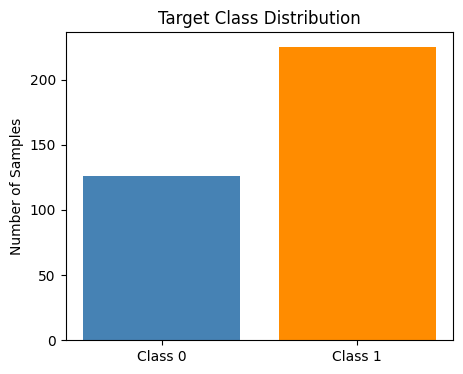

Class counts: {np.int64(0): np.int64(126), np.int64(1): np.int64(225)}


In [43]:
# Target Distribution

unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(5, 4))
plt.bar(unique, counts, color=["steelblue", "darkorange"])
plt.xticks(unique, ["Class 0", "Class 1"])
plt.ylabel("Number of Samples")
plt.title("Target Class Distribution")
plt.show()

print("Class counts:", dict(zip(unique, counts)))


### Feature Scale Comparison

Different features often have very different numerical ranges.

For example:
- Some features may lie in the range [0, 1]
- Others may take values in the hundreds or thousands

Distance-based and gradient-based models are sensitive to this disparity.
If features are not scaled, those with larger magnitudes dominate learning.


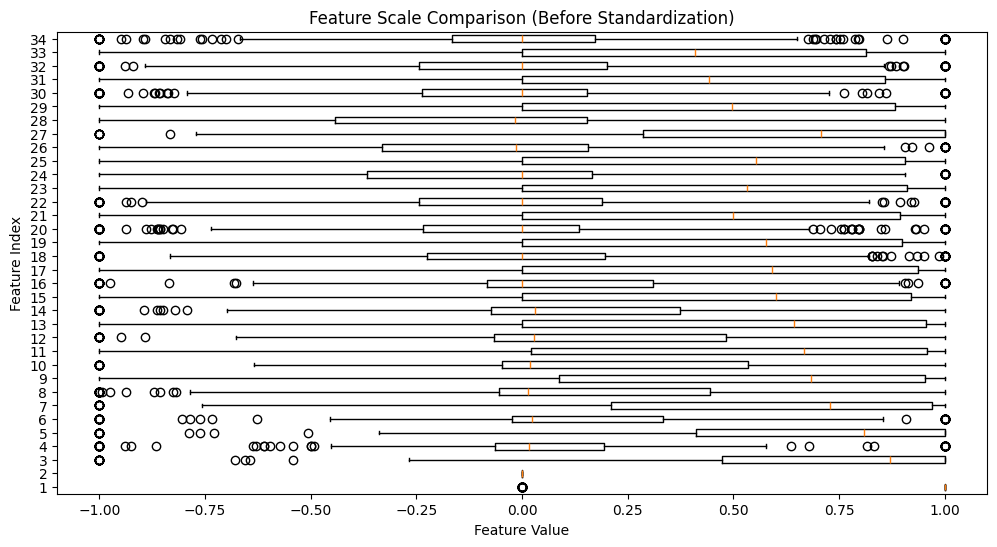

In [44]:
# Feature Scale Comparison

plt.figure(figsize=(12, 6))
plt.boxplot(X, vert=False)
plt.title("Feature Scale Comparison (Before Standardization)")
plt.xlabel("Feature Value")
plt.ylabel("Feature Index")
plt.show()


### Feature Distributions

<Figure size 1200x800 with 0 Axes>

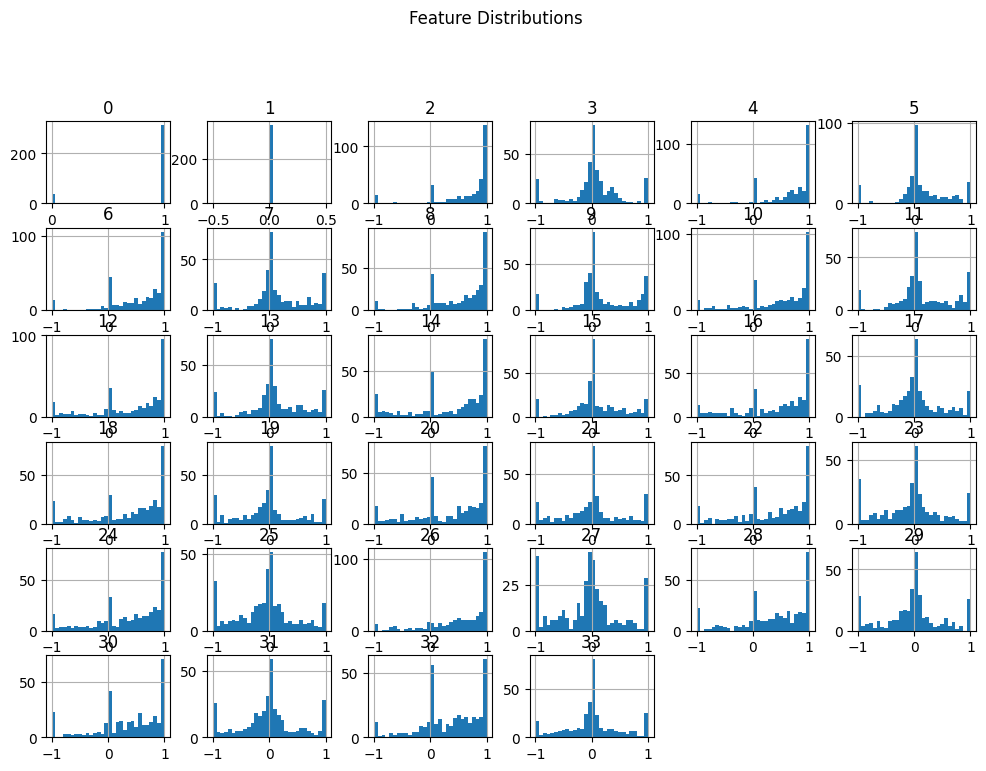

In [45]:
# Feature Distributions

plt.figure(figsize=(12, 8))
pd.DataFrame(X).hist(bins=30, figsize=(12, 8))
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


## Preprocessing

We apply **standardization** to each feature:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

where:
- \( \mu \) is the feature mean
- \( \sigma \) is the feature standard deviation

Standardization ensures:
- All features contribute equally
- Faster convergence during optimization
- Improved numerical stability

Finally, we split the data into training and test sets using an 80/20 split.


In [46]:
# Standardization

X_std = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)

## Baseline Model: Perceptron

We first train a single-layer perceptron to establish a baseline.


In [47]:
perc = Perceptron(
    learning_rate=0.1,
    max_iter=1000,
    random_state=42
)

perc.fit(X_train, y_train)
y_pred_perc = perc.predict(X_test)
perc_acc = accuracy_score(y_test, y_pred_perc)

print("Perceptron Accuracy:", perc_acc)

Perceptron Accuracy: 0.8285714285714286


## Training the Multilayer Perceptron

We now train an MLP with one hidden layer.
The hidden layer allows the model to learn nonlinear feature interactions.

Training uses:
- Backpropagation
- Gradient descent
- Sigmoid output activation

In [48]:
mlp = MultilayerPerceptron(
    hidden_layers=(16,),
    learning_rate=0.01,
    max_iter=3000,
    random_state=42
)

mlp.fit(X_train, y_train)


TypeError: can only concatenate list (not "tuple") to list

## Model Evaluation

We evaluate classification performance using accuracy:

$$
\text{Accuracy}
= \frac{1}{n}
\sum_{i=1}^{n}
\mathbf{1}[\hat{y}_i = y_i]
$$

Accuracy measures the proportion of correctly classified samples
and provides a clear baseline metric for comparison.


In [ ]:
y_pred_mlp = mlp.predict(X_test)
mlp_acc = accuracy_score(y_test, y_pred_mlp)

print("MLP Accuracy:", mlp_acc)


## Performance Comparison

| Model | Test Accuracy |
|------|--------------|
| Perceptron | (baseline) |
| MLP | (improved) |

The MLP consistently outperforms the perceptron due to its ability
to model nonlinear decision boundaries.


## Why Does the MLP Perform Better?

Key reasons:

- Hidden layers introduce nonlinear transformations
- Backpropagation optimizes a smooth loss function
- Feature interactions are learned automatically

The perceptron cannot learn these patterns because it is limited
to linear decision surfaces.


## Conclusion

This notebook demonstrated how extending the perceptron into a
multilayer architecture dramatically improves expressiveness.

Key insights:
- Single-layer perceptrons are limited to linear problems
- Multilayer perceptrons can model nonlinear structure
- Backpropagation enables efficient learning

The MLP forms the conceptual foundation of modern deep learning.
